# Data Exploration
This notebook explores GDPR Textual data by performing the following operations:
- Computing token and bigrams frequencies in each chapter
- Exploring TF-IDF clusters
- Exploring clusters through LLM representations
- Exploring Topics via LDA

In [ ]:
import json
from collections import Counter
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE
import plotly.express as px
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import re
from tqdm import tqdm
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary

c:\Users\faceru\OneDrive - SAS\Documents\Personal\GDPR_Assistant\GDPR_NLP\gdpr_env\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [ ]:
with open('../../data/chunked_data/gdpr_clean.json') as f: 
    gdpr_clean = json.load(f)

### Descriptive Statistics

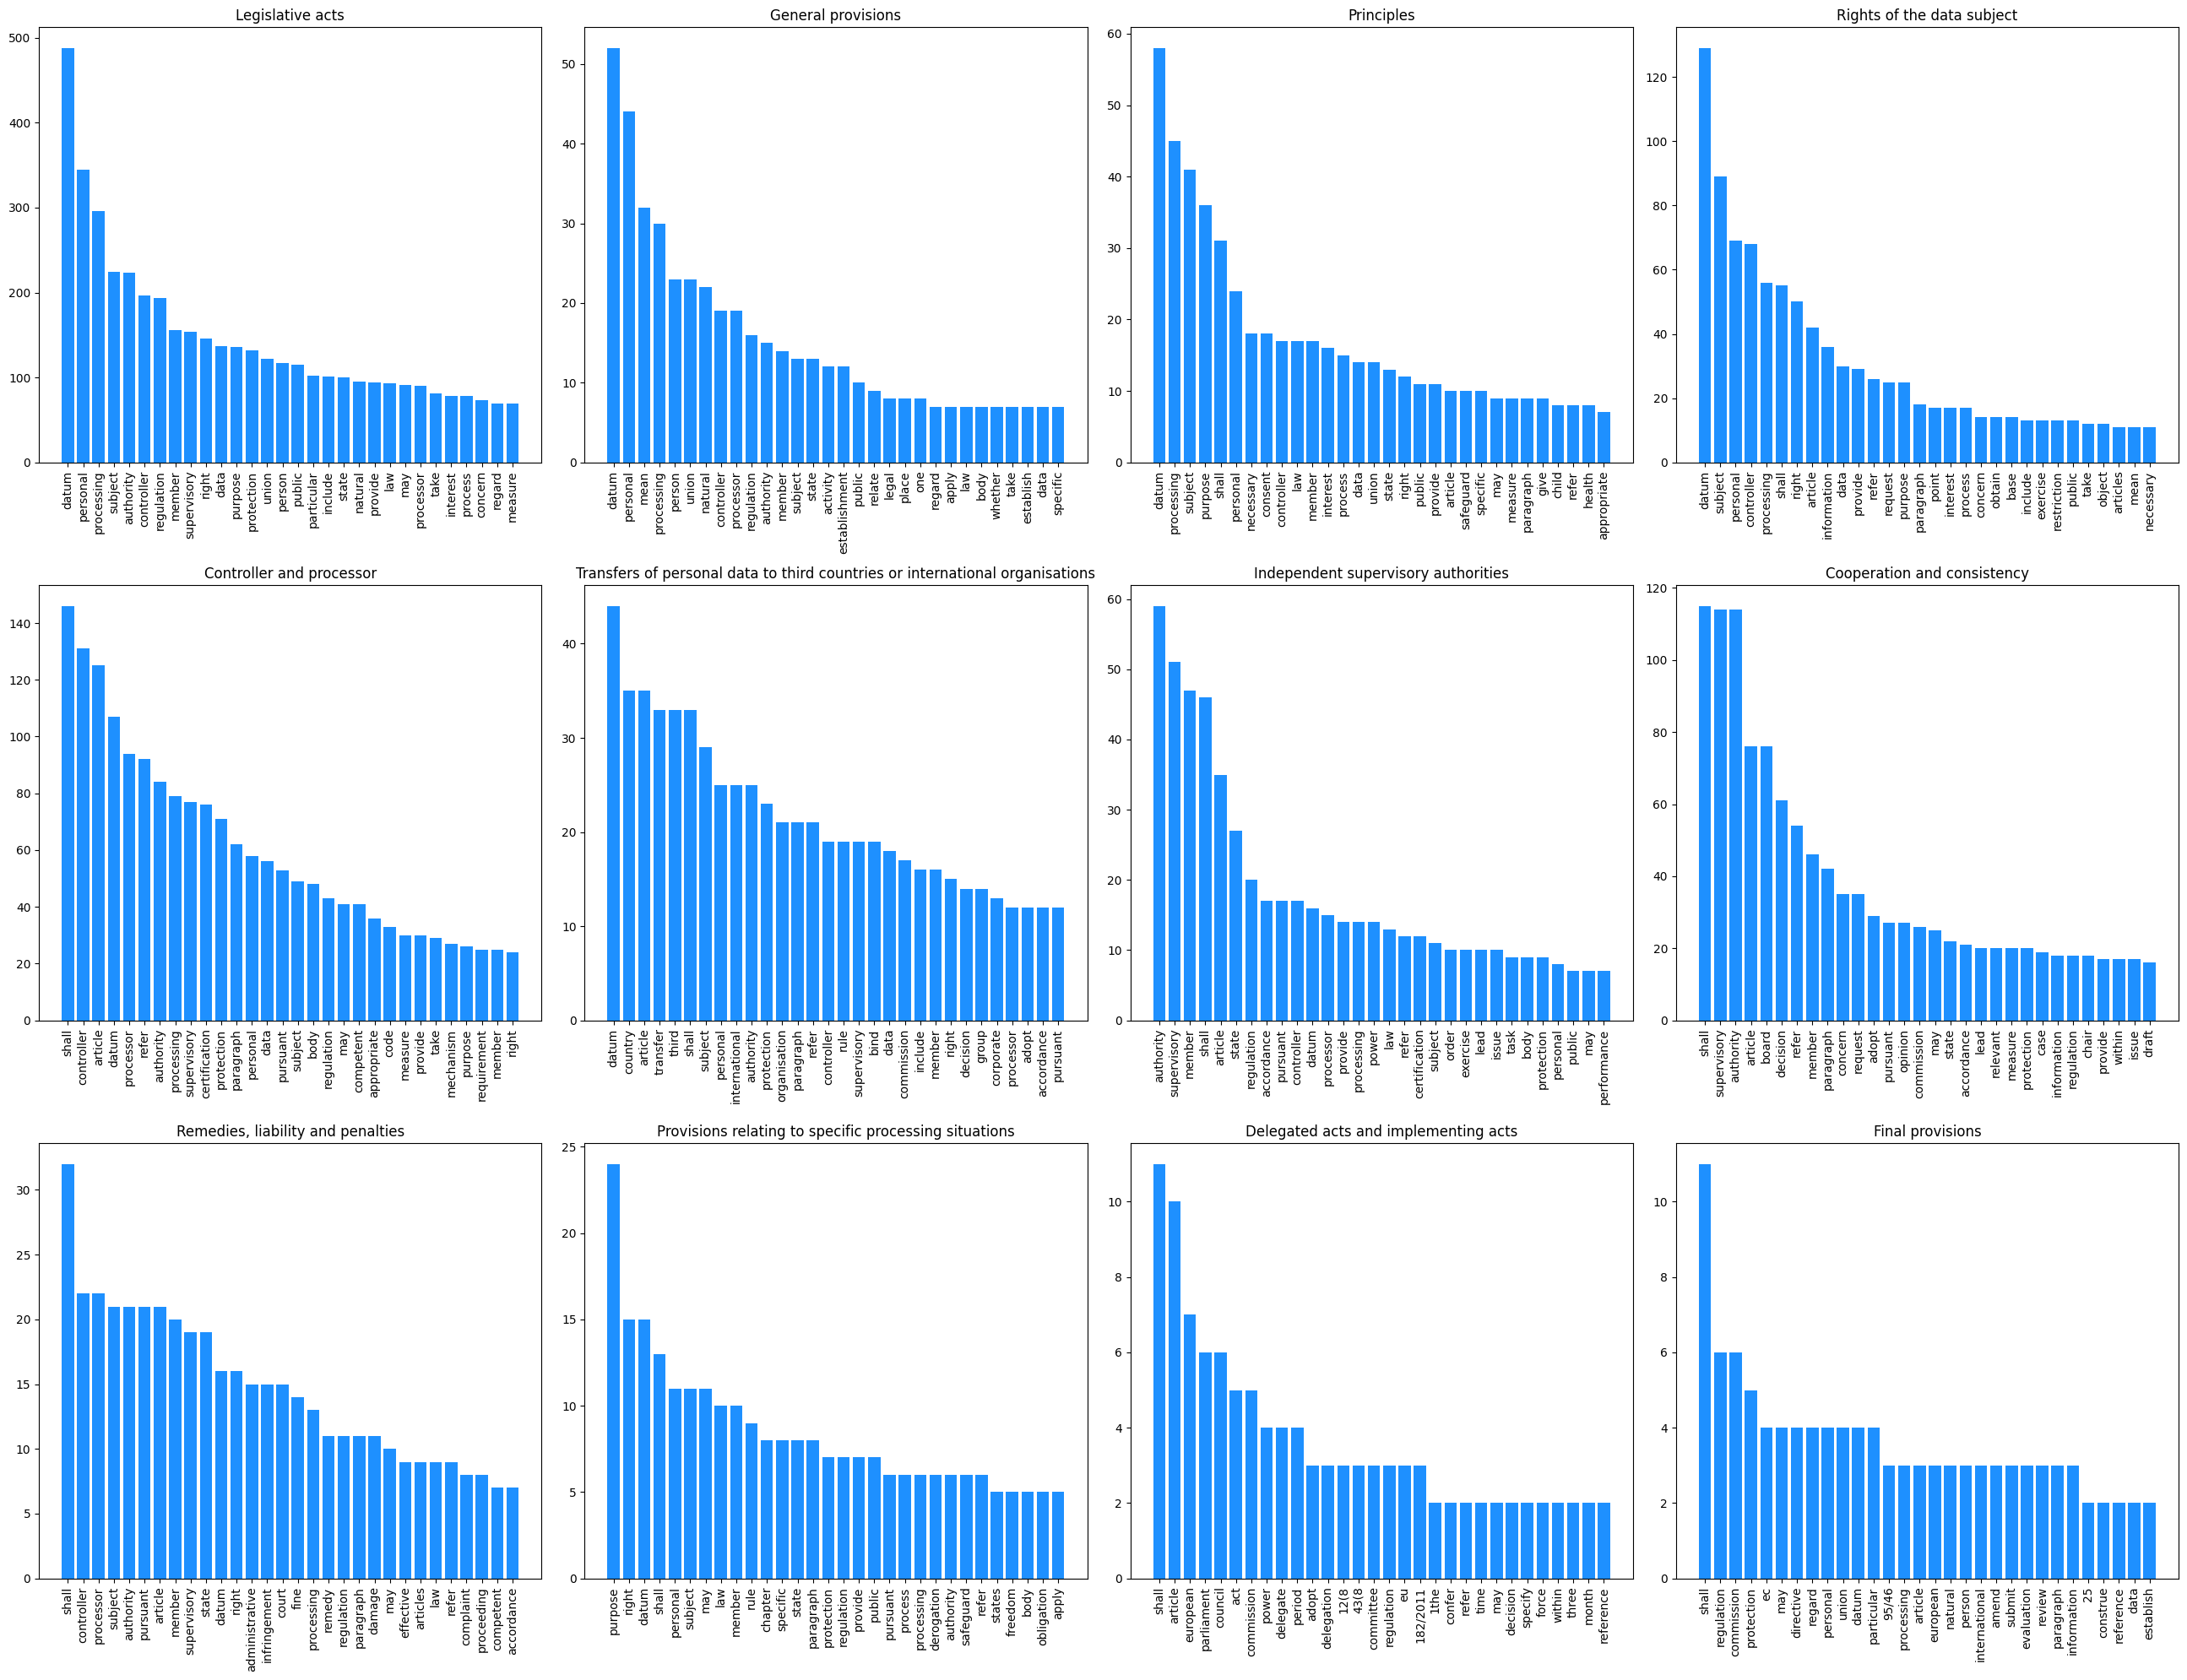

In [3]:
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(26,20))
axs=axs.ravel()
chapters = list(gdpr_clean.keys())
for i in range(len(axs)):
    ax = axs[i]
    chapter = chapters[i]
    top_20_words = Counter(' '.join(gdpr_clean[chapter].values()).split()).most_common(30)
    x_labs = [x for x,y in top_20_words]
    y_vals = [y for x,y in top_20_words]
    ax.bar(x=x_labs, height=y_vals, color='dodgerblue')
    ax.set_title(f'{chapter}')
    ax.tick_params(axis='x', labelrotation=90)

plt.tight_layout()    
plt.show()

In [4]:
#nltk.download('punkt_tab')

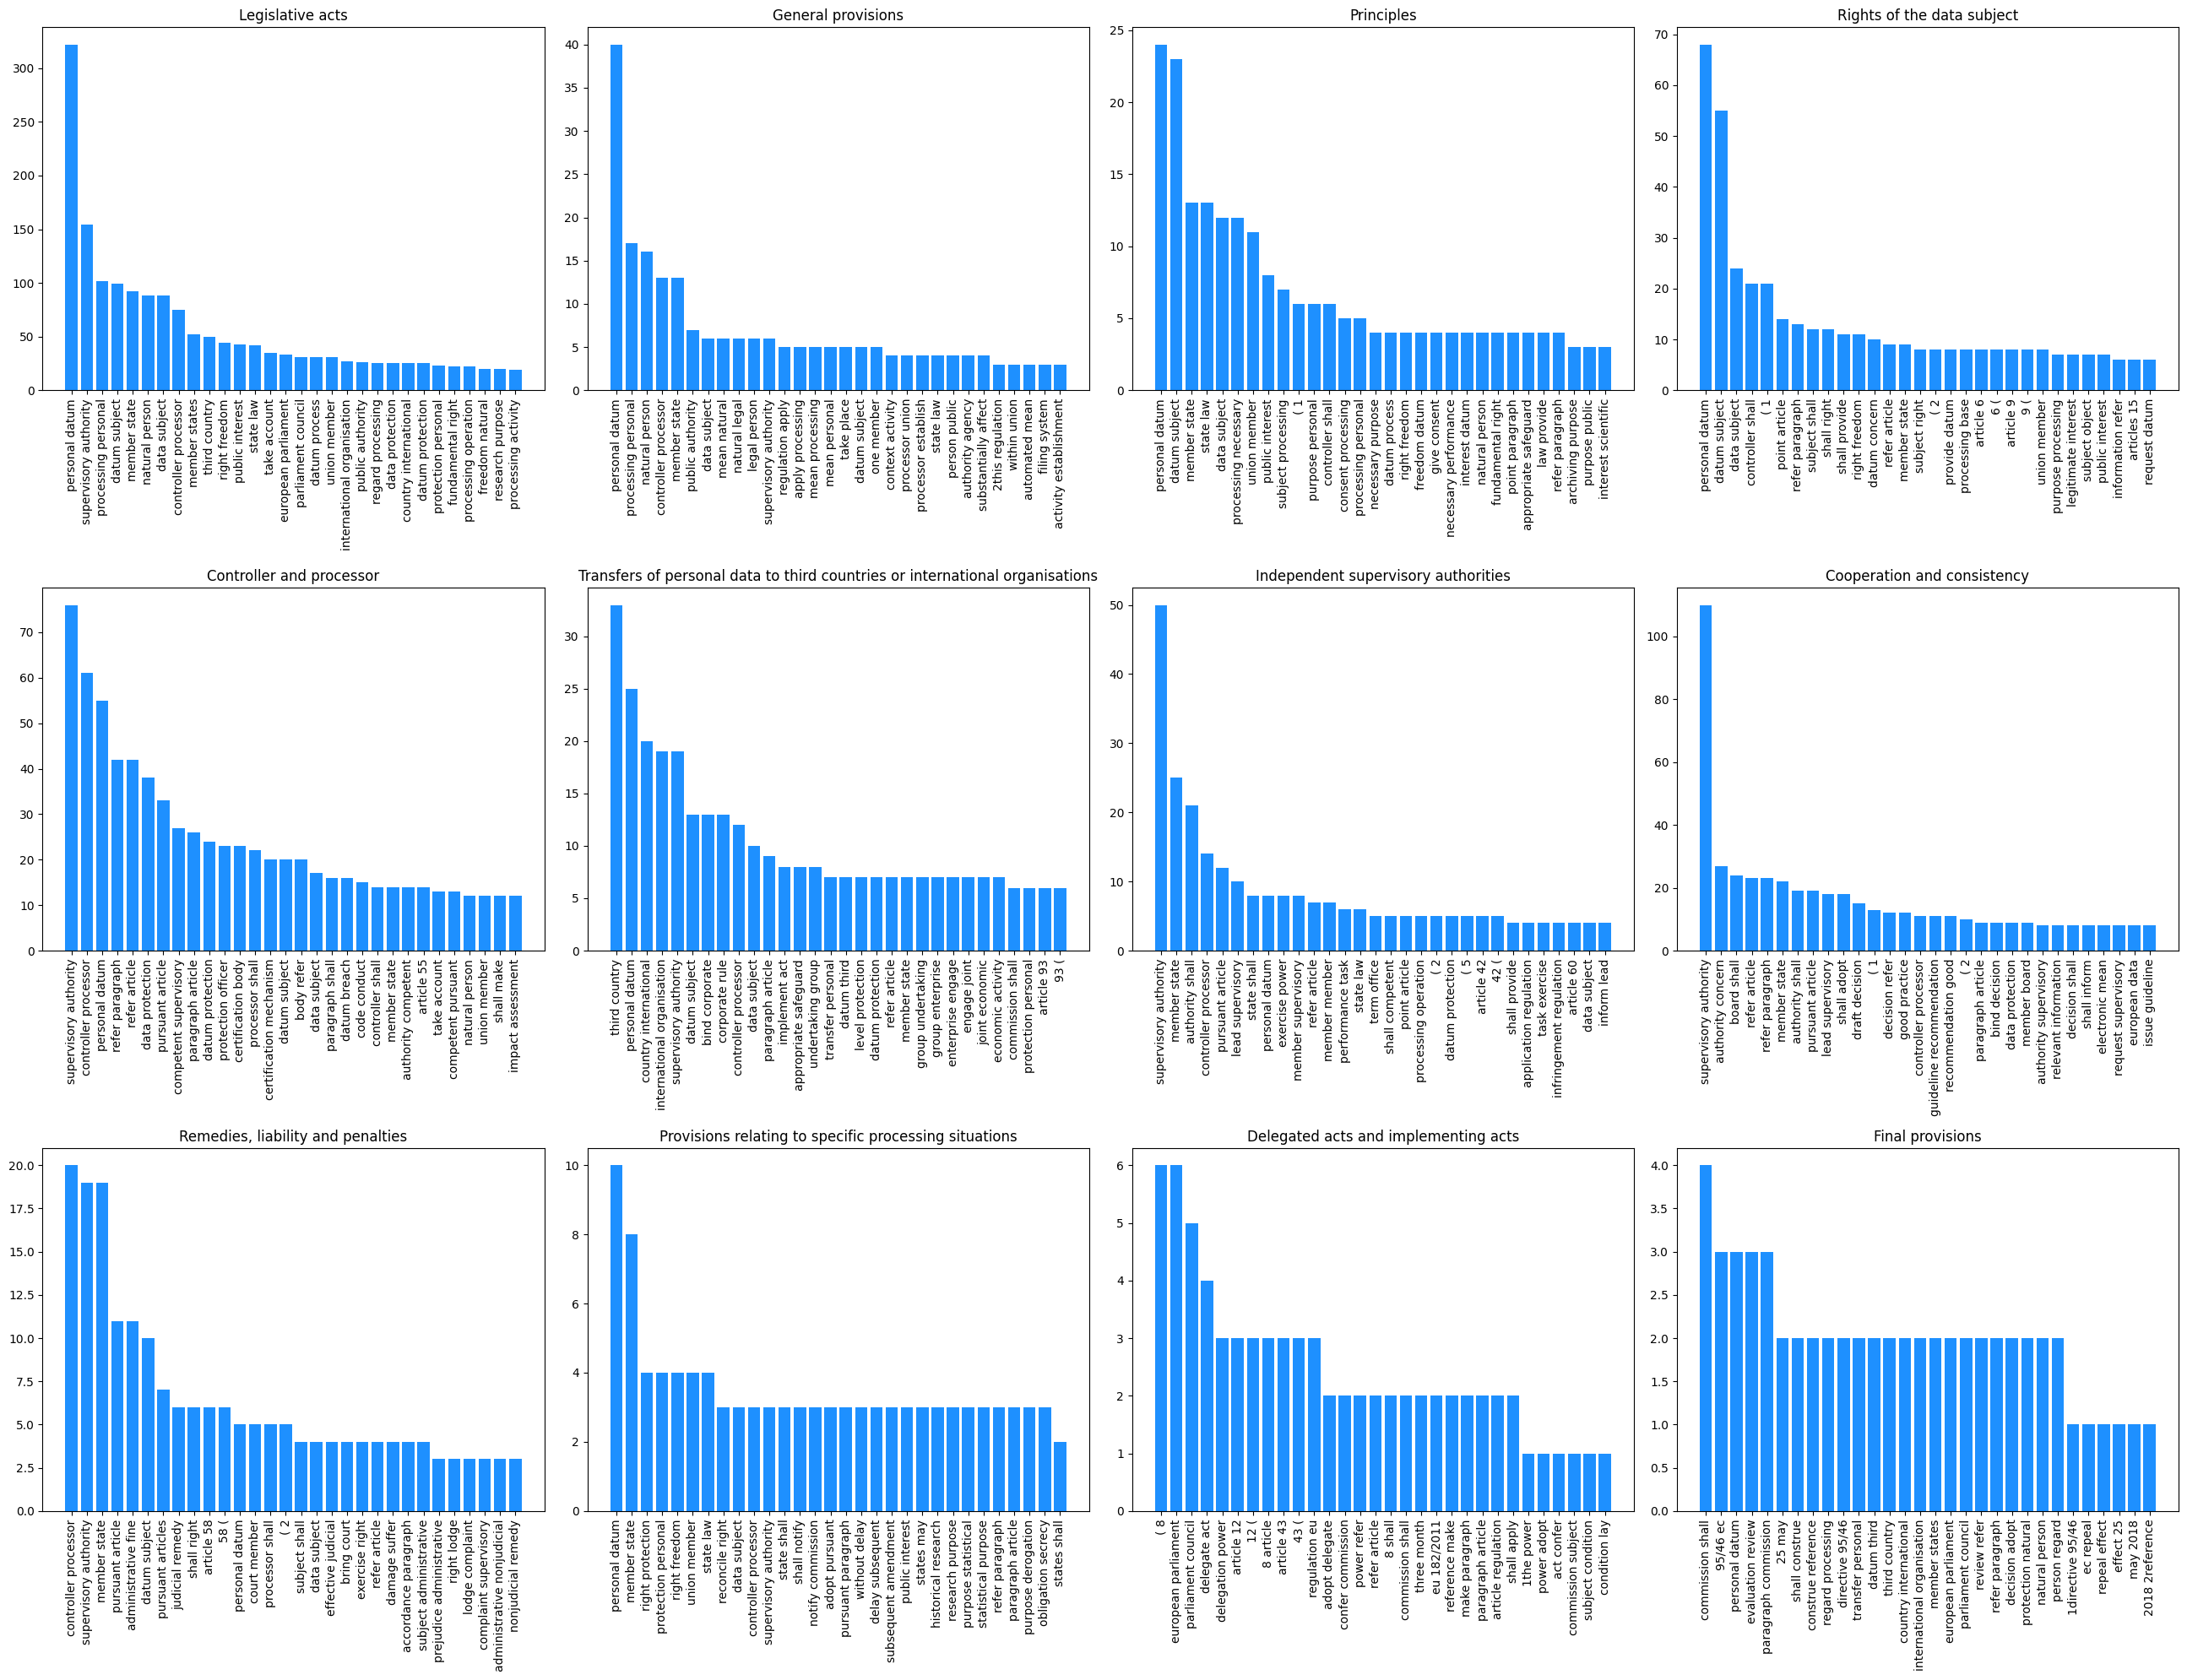

In [5]:
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(26,20))
axs=axs.ravel()
for i in range(len(axs)):
    ax = axs[i]
    chapter = chapters[i]
    top_20_bigrams = Counter([k for k in nltk.bigrams(word_tokenize(''.join(gdpr_clean[chapter].values())))]).most_common(30)
    x_labs = [x for x,y in top_20_bigrams]
    x_labs = [k[0]+' '+k[1] for k in x_labs]
    y_vals = [y for x,y in top_20_bigrams]
    ax.bar(x=x_labs, height=y_vals, color='dodgerblue')
    ax.set_title(f'{chapter}')
    ax.tick_params(axis='x', labelrotation=90)

plt.tight_layout()    
plt.show()

### TF-IDF

In [ ]:
articles = [re.sub('[0-9]*','',gdpr_clean[i][k]) for i in gdpr_clean.keys() for k in gdpr_clean[i].keys() if i!= 'Legislative acts'] #remove all numbers as they clutter the words

tfidf_vectorizer=TfidfVectorizer(min_df=0.05, #I am considering words that appear at least in 5% of the articles
                                 max_df=0.65, #I am considering words that appear at most in 65% of the articles
                                 ngram_range=(1,2)) 

vectors = tfidf_vectorizer.fit_transform(articles)
feature_names=tfidf_vectorizer.get_feature_names_out()

In [7]:
tfidf_embeddings = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42).fit_transform(vectors)
tfidf_rep = pd.DataFrame({'Chapter': [i for i in gdpr_clean.keys() for k in gdpr_clean[i].keys() if i!= 'Legislative acts'], 
                          'X_Embedding': tfidf_embeddings[:,0],
                          'Y_Embedding': tfidf_embeddings[:,1]})

px.scatter(tfidf_rep, 'X_Embedding', 'Y_Embedding', color='Chapter', color_discrete_sequence=px.colors.qualitative.Dark24)

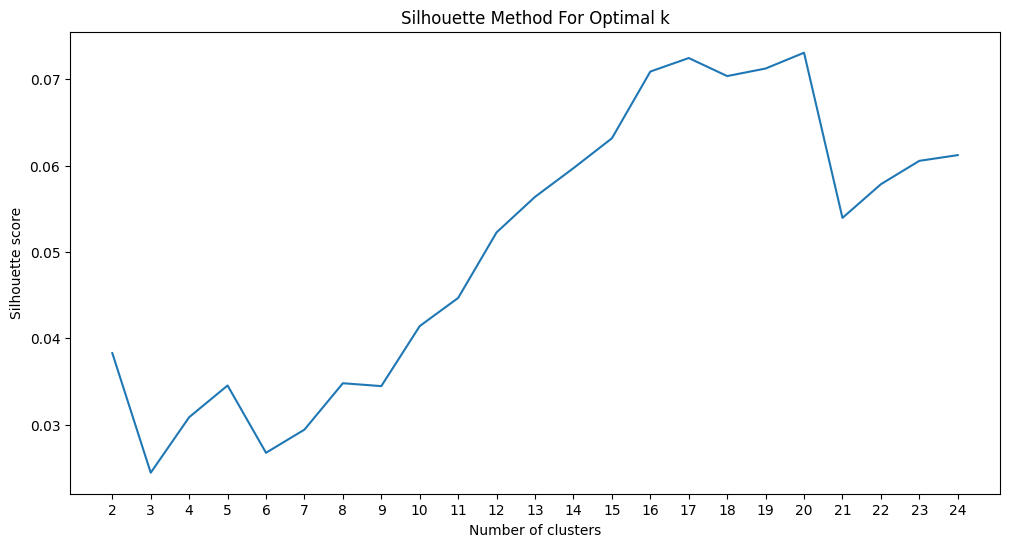

In [ ]:
silhouettes = []
K = range(2, 25)

for c in K:
    kmeans_clustering = KMeans(n_clusters=c, init='k-means++', max_iter=1500, random_state=42, tol=1e-6)
    kmeans_ids = kmeans_clustering.fit_predict(vectors)
    score = silhouette_score(vectors, kmeans_clustering.labels_)
    silhouettes.append(score)

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(K, silhouettes)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_title('Silhouette Method For Optimal k')
ax.set_xticks(np.arange(min(K), max(K)+1, 1.0))

plt.show()

In [9]:
clusters=16
model=KMeans(n_clusters=clusters, init='k-means++', max_iter=1500, random_state=42, tol=1e-6)
model.fit(vectors)
order_centroids=model.cluster_centers_.argsort()[:, ::-1]

for i in range(clusters):
    l=[]
    for j in order_centroids[i, :15]: #keeping only the first 15 words
        l.append(feature_names[j])
    print(f'Cluster {i}: {l}')

Cluster 0: ['processor', 'controller processor', 'officer', 'protection officer', 'controller', 'protection', 'damage', 'processor shall', 'data protection', 'processing', 'datum protection', 'task', 'data', 'the', 'the datum']
Cluster 1: ['datum subject', 'controller', 'personal datum', 'processing', 'right', 'information', 'controller shall', 'subject shall', 'shall right', 'purpose', 'recipient', 'request', 'refer', 'provide', 'process']
Cluster 2: ['processing', 'right', 'controller', 'consent', 'interest', 'public', 'personal datum', 'datum subject', 'data', 'official', 'union member', 'law', 'safeguard', 'data subject', 'state law']
Cluster 3: ['chapter', 'amendment', 'state shall', 'each', 'infringement', 'pursuant', 'notify commission', 'amendment affect', 'delay subsequent', 'subsequent amendment', 'each member', 'subsequent', 'law', 'rule', 'law adopt']
Cluster 4: ['assessment', 'type', 'impact', 'supervisory', 'supervisory authority', 'processing', 'list', 'report', 'control

In [10]:
clust_dict = {0:'Controller and Processor',
              1:'Processing Personal Data',
              2:'Processing Consent',
              3:'GDPR Adoption',
              4:'Controller Obligations',
              5:'Board and Supervisory Authority',
              6:'Supervisory/Certification Authority',
              7:'Supervisory Authority Power',
              8:'Natural Person',
              9:'Organisational Measures',
              10:'EU Board Approval',
              11:'EU Bodies',
              11:'Personal Data Subjects',
              12:'Application Consistency',
              13:'International Data Transfers',
              14:'Purpose of Collection',
              15:'Data Breach Consequences'}

In [11]:
tfidf_rep['Cluster'] = model.predict(vectors) 
tfidf_rep['Cluster_Type'] = tfidf_rep['Cluster'].map(clust_dict)
px.scatter(tfidf_rep, 'X_Embedding', 'Y_Embedding', color='Cluster_Type', color_discrete_sequence=px.colors.qualitative.Dark24)

### LLM Embeddings

In [15]:
model = SentenceTransformer('intfloat/multilingual-e5-large-instruct') 
embeddings = []
chapter = [i for i in gdpr_clean.keys() for k in gdpr_clean[i].keys() if i!= 'Legislative acts']
for art in tqdm(articles): 
    embeddings.append(model.encode(art, normalize_embeddings=True))
embeddings = np.array(embeddings)

100%|██████████| 98/98 [01:08<00:00,  1.43it/s]


In [16]:
embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42).fit_transform(embeddings)
embedded_df = pd.DataFrame({'x': embedded[:,0], 'y':embedded[:,1], 'chapter':chapter})
px.scatter(embedded_df, 'x', 'y', color='chapter', color_discrete_sequence=px.colors.qualitative.Dark24)

### Topic Modelling

In [33]:
splitted_articles = [art.split(' ') for art in articles]
dictionary = Dictionary(splitted_articles)
dictionary.filter_extremes(no_above=0.6, no_below=1)
ldacorpus = [dictionary.doc2bow(i) for i in splitted_articles]
tfidf = TfidfModel(ldacorpus)
model_corpus = tfidf[ldacorpus]

numtop=[]
coherence_umass = []
coherence_cv=[]

for num_topics in tqdm(range(5, 30)): 
    model = LdaMulticore(corpus=model_corpus, 
                         id2word=dictionary, 
                         num_topics=num_topics, random_state=42,
                         passes=10)     

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=splitted_articles, 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=splitted_articles, 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    numtop.append(num_topics)
    coherence_umass.append(umass_score)
    coherence_cv.append(cv_score)

100%|██████████| 25/25 [09:27<00:00, 22.70s/it]


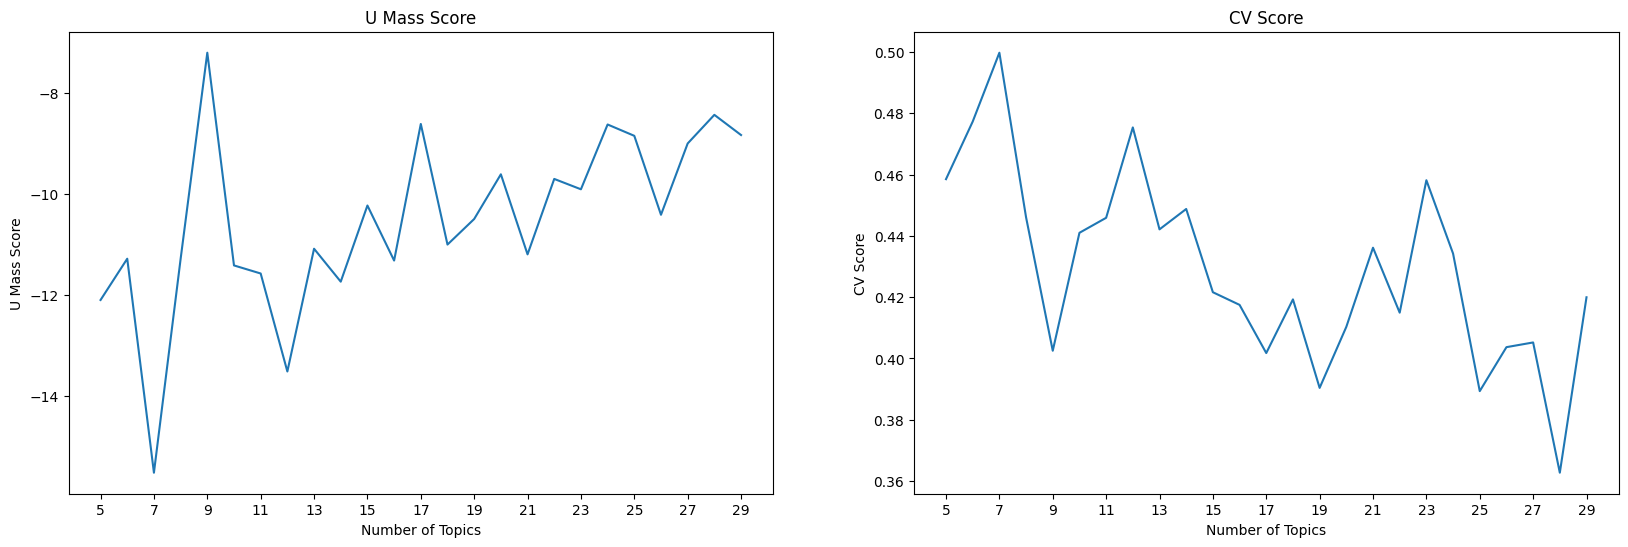

In [34]:
fig, axs= plt.subplots(ncols = 2, figsize=(20,6))

ax=axs[0]
ax.set_title('U Mass Score')
ax.set_xlabel('Number of Topics')
ax.set_ylabel('U Mass Score')
ax.plot(numtop, coherence_umass)
ax.set_xticks(np.arange(5, 30, 2))

ax=axs[1]
ax.set_title('CV Score')
ax.set_xlabel('Number of Topics')
ax.set_ylabel('CV Score')
ax.plot(numtop, coherence_cv)
ax.set_xticks(np.arange(5, 30, 2))

plt.show()

In [35]:
topics=9
passes = 30 

model = LdaMulticore(num_topics=topics, 
                     corpus=model_corpus,  
                     id2word=dictionary, 
                     passes=passes, 
                     random_state=42,
                     iterations=30 
                    )

In [36]:
model_topics = [(topic_no, re.sub(r'0\.[0-9]+\*', '', model_topic).replace('"', '').split(' + ')) for topic_no, model_topic in model.print_topics(num_topics=topics, num_words=15)]

for i, m in model_topics:
    print(f'Topic {i}:', ", ".join(m[:15])) 

Topic 0: supervisor, official, section, construe, reference, control, directive, confer, conviction, secretariat, network, supervise, assign, concerned, automated
Topic 1: court, type, throughout, report, section, contribute, seize, proceeding, consistent, pende, first, icon, officer, contact, annual
Topic 2: majority, operational, organise, staff, mandate, twothird, host, damage, behalf, cause, simple, arrangement, otherwise, active, in­dependently
Topic 3: group, secrecy, identifier, committee, work, each, eu, economic, undertaking, identification, engage, examination, consistent, employment, arrangement
Topic 4: document, date, govern, official, identification, confidential, council, force, revoke, delegation, conclude, discussion, replace, expert, delegate
Topic 5: officer, recipient, restriction, interest, duty, suitable, erasure, legitimate, obtain, object, health, urgent, base, report, time
Topic 6: purpose, union, this, law, process, person, processor, legal, natural, technical